# Lab 1 - Adverserial Attacks
#### Theodor Jonsson - thjo0148@student.umu.se
#### Date: 2023-12-06
During this lab i will be using the source from the provided [tutorial](https://debuggercafe.com/traffic-sign-recognition-using-pytorch-and-deep-learning/) and the [GTSRB dataset](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) to train a model to recognize traffic signs. I will utilize the supplied source code and import the necessary functions and classes to this notebook from the source code provided to train/find-tune the model, if any changes has made to the source code it will be noted in this notebook and if further insight into the code is needed it can be found on my GitHub [here](https://github.com/Tottowich/SAAV), where this code and the source code is available.

## Dataset - GTSRB (German Traffic Sign Recognition Benchmark)

The dataset consists of more than $50,000$ images of traffic signs from $43$ different classes. The dataset has been a benchmark for multiple years and has been evaluated using various methods.
The dataset is downloaded from following the instuctions of the tutotrial and are available both on [Kaggle](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) and [ERDA](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html) (Electronic Research Data Archieve).

In [3]:
from datasets import get_datasets, get_data_loaders # Altered source code to take input arguments, rather than hard-coded values.
# Define dataset parameters.
validation_split = 0.15 # Default value.
batch_size       = 256 # Default value.
num_workers      = 12  # This was the fastest value for my system.

dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid, batch_size, num_workers)

[INFO]: Number of training images: 35289
[INFO]: Number of validation images: 3920
[INFO]: Class names: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']



## Model - MobileNetV3 (Large)
Training a model from scratch may be time consuming as vision models, especially CNN-based models, tend to learn similary feature extractors. Therefore we will be fine-tuning a pre-trained model, [MobileNetV3](https://arxiv.org/pdf/1905.02244.pdf) (Large). The model is pre-trained on the large-scale [ImageNet](https://www.image-net.org/) dataset which as of december 2023 contains more than 14 million images.

In [4]:
from model import build_model
from train import train, validate
import torch
import time

hyps = { # Defining the default hyperparameters. Found as CLI arguments in train.py
    'epochs': 10,
    'learning_rate': 0.001,
    'pretrained': True,
    'fine_tune': True
}

# Learning_parameters. 
lr = hyps['learning_rate']
epochs = hyps['epochs']
device = ('cuda' if torch.cuda.is_available() else 'mps')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")
# Load the model.
model = build_model(
    pretrained=hyps['pretrained'],
    fine_tune=hyps['fine_tune'], 
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

## Training
With the model defined and the dataset downloaded we can now start the training. The training was done on a Nvidia 3060 Ti GPU with 8GB of VRAM. In the following section i have made some modifications compared to the original source code by including Mixed Precision Training for faster training and less memory usage.

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.cuda.amp import GradScaler
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10, 
    T_mult=1,
    verbose=False
)
scaler = GradScaler() # For faster mixed precision training.
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, train_loader, 
        optimizer, scaler, criterion,
        scheduler=scheduler, epoch=epoch
    )
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion, dataset_classes)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print(f"Learning rate: {scheduler.get_last_lr()[0]:.2e}")
    print('-'*50)
    # time.sleep(5)

[INFO]: Epoch 1 of 10
Training


100%|██████████| 138/138 [00:53<00:00,  2.59it/s]

Validation



100%|██████████| 16/16 [00:03<00:00,  4.03it/s]



Accuracy of class 00000: 78.26086956521739
Accuracy of class 00001: 98.5781990521327
Accuracy of class 00002: 94.7867298578199
Accuracy of class 00003: 92.66666666666667
Accuracy of class 00004: 100.0
Accuracy of class 00005: 91.86046511627907
Accuracy of class 00006: 80.0
Accuracy of class 00007: 96.03174603174604
Accuracy of class 00008: 91.66666666666667
Accuracy of class 00009: 97.1830985915493
Accuracy of class 00010: 100.0
Accuracy of class 00011: 92.8
Accuracy of class 00012: 100.0
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 96.42857142857143
Accuracy of class 00020: 79.16666666666667
Accuracy of class 00021: 82.3529411764706
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 96.45390070921985
Accuracy of class 00026: 94.8051948051948



100%|██████████| 138/138 [00:37<00:00,  3.64it/s]

Validation



100%|██████████| 16/16 [00:03<00:00,  5.11it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 100.0
Accuracy of class 00002: 99.5260663507109
Accuracy of class 00003: 98.66666666666667
Accuracy of class 00004: 98.9795918367347
Accuracy of class 00005: 94.18604651162791
Accuracy of class 00006: 100.0
Accuracy of class 00007: 100.0
Accuracy of class 00008: 100.0
Accuracy of class 00009: 98.59154929577464
Accuracy of class 00010: 100.0
Accuracy of class 00011: 100.0
Accuracy of class 00012: 99.53917050691244
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 98.0
Accuracy of class 00017: 96.21212121212122
Accuracy of class 00018: 100.0
Accuracy of class 00019: 92.85714285714286
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 99.29078014184397
Accuracy of class 00026: 100.0
Accuracy of class 00027: 86.95652173913044
A


100%|██████████| 138/138 [00:38<00:00,  3.61it/s]

Validation



100%|██████████| 16/16 [00:02<00:00,  5.40it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 100.0
Accuracy of class 00002: 99.5260663507109
Accuracy of class 00003: 100.0
Accuracy of class 00004: 100.0
Accuracy of class 00005: 98.83720930232558
Accuracy of class 00006: 100.0
Accuracy of class 00007: 100.0
Accuracy of class 00008: 100.0
Accuracy of class 00009: 98.59154929577464
Accuracy of class 00010: 99.49238578680203
Accuracy of class 00011: 100.0
Accuracy of class 00012: 100.0
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 100.0
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 99.29078014184397
Accuracy of class 00026: 100.0
Accuracy of class 00027: 78.26086956521739
Accuracy of class 00028: 100.0
Accuracy of clas


100%|██████████| 138/138 [00:37<00:00,  3.64it/s]

Validation



100%|██████████| 16/16 [00:02<00:00,  5.36it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 99.5260663507109
Accuracy of class 00002: 100.0
Accuracy of class 00003: 98.0
Accuracy of class 00004: 97.44897959183673
Accuracy of class 00005: 100.0
Accuracy of class 00006: 100.0
Accuracy of class 00007: 98.41269841269842
Accuracy of class 00008: 100.0
Accuracy of class 00009: 100.0
Accuracy of class 00010: 99.49238578680203
Accuracy of class 00011: 100.0
Accuracy of class 00012: 100.0
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 100.0
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 96.42857142857143
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 67.6470588235294
Accuracy of class 00025: 99.29078014184397
Accuracy of class 00026: 98.7012987012987
Accuracy of class 00027: 100.0
Accuracy of class 00028: 97.7272727272


100%|██████████| 138/138 [00:38<00:00,  3.59it/s]

Validation



100%|██████████| 16/16 [00:02<00:00,  5.41it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 100.0
Accuracy of class 00002: 99.0521327014218
Accuracy of class 00003: 100.0
Accuracy of class 00004: 100.0
Accuracy of class 00005: 98.83720930232558
Accuracy of class 00006: 100.0
Accuracy of class 00007: 100.0
Accuracy of class 00008: 99.24242424242425
Accuracy of class 00009: 100.0
Accuracy of class 00010: 100.0
Accuracy of class 00011: 100.0
Accuracy of class 00012: 100.0
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 100.0
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 99.29078014184397
Accuracy of class 00026: 100.0
Accuracy of class 00027: 100.0
Accuracy of class 00028: 97.72727272727273
Accuracy of class 00029: 100


100%|██████████| 138/138 [00:36<00:00,  3.74it/s]

Validation



100%|██████████| 16/16 [00:02<00:00,  5.52it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 100.0
Accuracy of class 00002: 99.0521327014218
Accuracy of class 00003: 100.0
Accuracy of class 00004: 100.0
Accuracy of class 00005: 100.0
Accuracy of class 00006: 100.0
Accuracy of class 00007: 99.2063492063492
Accuracy of class 00008: 100.0
Accuracy of class 00009: 100.0
Accuracy of class 00010: 100.0
Accuracy of class 00011: 100.0
Accuracy of class 00012: 100.0
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 100.0
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 99.29078014184397
Accuracy of class 00026: 100.0
Accuracy of class 00027: 91.30434782608695
Accuracy of class 00028: 100.0
Accuracy of class 00029: 100.0
Accuracy o


100%|██████████| 138/138 [00:36<00:00,  3.74it/s]

Validation



100%|██████████| 16/16 [00:02<00:00,  5.57it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 99.5260663507109
Accuracy of class 00002: 99.0521327014218
Accuracy of class 00003: 100.0
Accuracy of class 00004: 100.0
Accuracy of class 00005: 100.0
Accuracy of class 00006: 100.0
Accuracy of class 00007: 100.0
Accuracy of class 00008: 100.0
Accuracy of class 00009: 100.0
Accuracy of class 00010: 100.0
Accuracy of class 00011: 100.0
Accuracy of class 00012: 99.53917050691244
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 100.0
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 99.29078014184397
Accuracy of class 00026: 100.0
Accuracy of class 00027: 100.0
Accuracy of class 00028: 100.0
Accuracy of class 00029: 100.0
Accuracy o


100%|██████████| 138/138 [00:37<00:00,  3.72it/s]

Validation



100%|██████████| 16/16 [00:02<00:00,  5.36it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 100.0
Accuracy of class 00002: 99.0521327014218
Accuracy of class 00003: 100.0
Accuracy of class 00004: 99.48979591836735
Accuracy of class 00005: 100.0
Accuracy of class 00006: 100.0
Accuracy of class 00007: 100.0
Accuracy of class 00008: 100.0
Accuracy of class 00009: 100.0
Accuracy of class 00010: 100.0
Accuracy of class 00011: 100.0
Accuracy of class 00012: 100.0
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 100.0
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 99.29078014184397
Accuracy of class 00026: 100.0
Accuracy of class 00027: 100.0
Accuracy of class 00028: 100.0
Accuracy of class 00029: 100.0
Accuracy of class 000


100%|██████████| 138/138 [00:37<00:00,  3.71it/s]

Validation



100%|██████████| 16/16 [00:02<00:00,  5.53it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 100.0
Accuracy of class 00002: 99.0521327014218
Accuracy of class 00003: 100.0
Accuracy of class 00004: 100.0
Accuracy of class 00005: 100.0
Accuracy of class 00006: 100.0
Accuracy of class 00007: 100.0
Accuracy of class 00008: 100.0
Accuracy of class 00009: 100.0
Accuracy of class 00010: 100.0
Accuracy of class 00011: 100.0
Accuracy of class 00012: 100.0
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 100.0
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 99.29078014184397
Accuracy of class 00026: 100.0
Accuracy of class 00027: 100.0
Accuracy of class 00028: 97.72727272727273
Accuracy of class 00029: 100.0
Accuracy of class 000


100%|██████████| 138/138 [00:37<00:00,  3.72it/s]

Validation



100%|██████████| 16/16 [00:02<00:00,  5.43it/s]



Accuracy of class 00000: 100.0
Accuracy of class 00001: 100.0
Accuracy of class 00002: 99.0521327014218
Accuracy of class 00003: 100.0
Accuracy of class 00004: 100.0
Accuracy of class 00005: 100.0
Accuracy of class 00006: 100.0
Accuracy of class 00007: 100.0
Accuracy of class 00008: 100.0
Accuracy of class 00009: 100.0
Accuracy of class 00010: 100.0
Accuracy of class 00011: 100.0
Accuracy of class 00012: 100.0
Accuracy of class 00013: 100.0
Accuracy of class 00014: 100.0
Accuracy of class 00015: 98.41269841269842
Accuracy of class 00016: 100.0
Accuracy of class 00017: 100.0
Accuracy of class 00018: 100.0
Accuracy of class 00019: 100.0
Accuracy of class 00020: 100.0
Accuracy of class 00021: 100.0
Accuracy of class 00022: 100.0
Accuracy of class 00023: 100.0
Accuracy of class 00024: 100.0
Accuracy of class 00025: 100.0
Accuracy of class 00026: 100.0
Accuracy of class 00027: 100.0
Accuracy of class 00028: 97.72727272727273
Accuracy of class 00029: 100.0
Accuracy of class 00030: 100.0
Ac

TRAINING COMPLETE


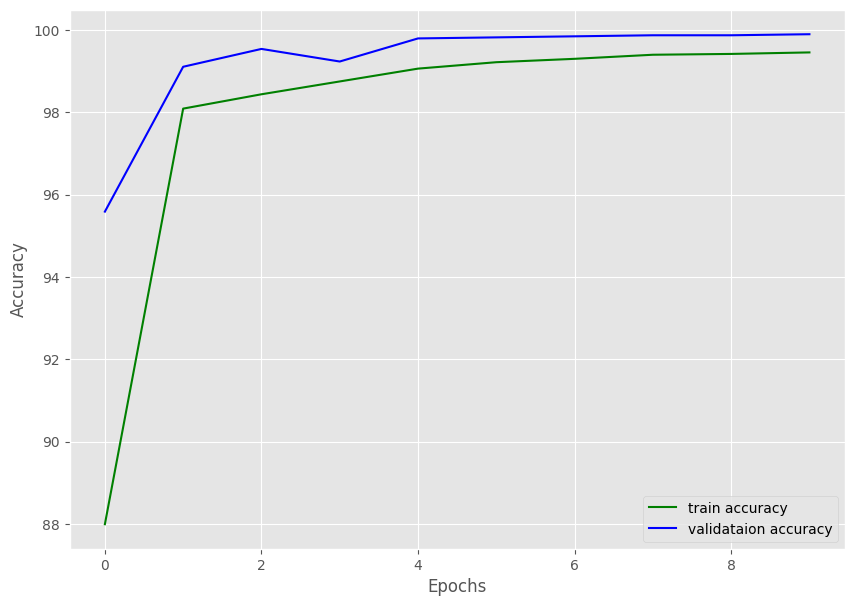

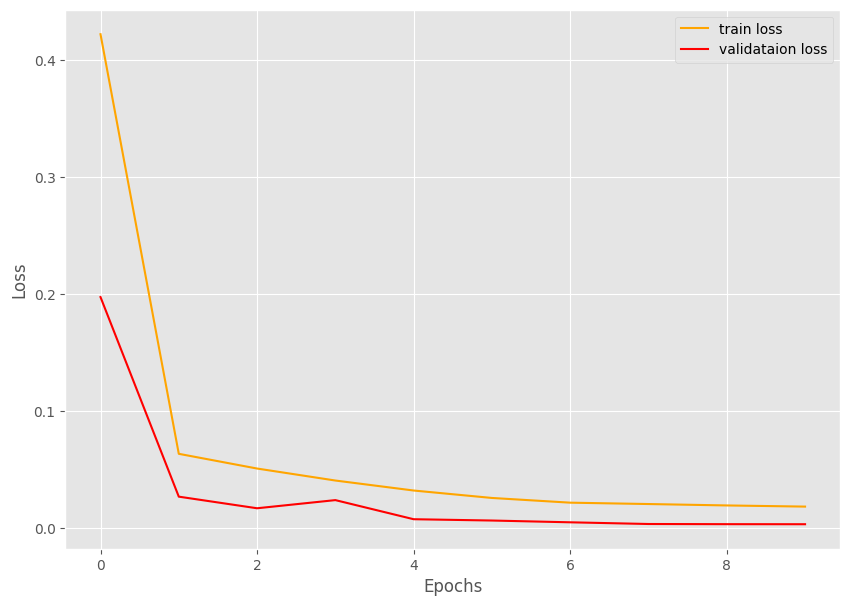

In [ ]:
from utils import save_model, save_plots
# Save the trained model weights.
save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

### Clear CUDA cache.

In [ ]:
torch.cuda.empty_cache() # Empty the cache to avoid memory leaks.

## Evaluation
With the model fine-tuned on th GTSRB dataset we can now evaluate the model's performance on the designated test set.

### Load the test set.
Loading the test set and the class names for the dataset.

In [ ]:
import pandas as pd
sign_names_df = pd.read_csv('../input/signnames.csv')
class_names = sign_names_df.SignName.tolist()
gt_df = pd.read_csv(
    '../input/GTSRB_Final_Test_GT/GT-final_test.csv', 
    delimiter=';'
)
gt_df = gt_df.set_index('Filename', drop=True)

### Prepare the model for evaluation.
Register a hook to the last convolutional layer of the model to extract the feature maps such that they can be visualized along with the original image. Since I am using PyTorch>=2.0 I will also compile the model for faster inference.

In [ ]:
import numpy as np
from model import build_model
import torch
features_blobs = []
device = torch.device('cuda')
model = build_model(
    pretrained=True,
    fine_tune=False, 
    num_classes=43
).to(device)
model = model.eval()
model.load_state_dict(
    torch.load(
        '../outputs/model.pth', map_location=device
    )['model_state_dict']
)
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('features').register_forward_hook(hook_feature)
# Save model parameters, 
weight_softmax = np.squeeze(list(model.parameters())[-4].data.cpu().numpy())

[INFO]: Loading pre-trained weights


/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Freezing hidden layers...


In [ ]:
import glob
import os

import albumentations as A
import cv2
import torch.nn.functional as F
from cam import apply_color_map, returnCAM, visualize_and_save_map

transform = A.Compose([ # Define same transform as used for validation set.
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    A.pytorch.ToTensorV2(),
    ])
all_images = glob.glob('../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*.ppm')

In [ ]:
from tqdm import tqdm
import time
counter       = 0
correct_count = 0
frame_count   = 0 # To count total frames.
total_fps     = 0 # To get the final frames per second. 
for i, image_path in tqdm(enumerate(all_images)):
    # Read the image.
    image = cv2.imread(image_path)
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = orig_image.shape
    # Apply the image transforms.
    image_tensor = transform(image=image)['image']
    # Add batch dimension.
    image_tensor = image_tensor.unsqueeze(0).to(device)
    # Forward pass through model.
    start_time = time.time()
    outputs = model(image_tensor)
    end_time = time.time()
    # Get the softmax probabilities.
    probs = F.softmax(outputs).data.squeeze()
    # Get the class indices of top k probabilities.
    class_idx = torch.topk(probs, 1)[1].int()
    # Get the ground truth.
    image_name = image_path.split(os.path.sep)[-1]
    gt_idx = gt_df.loc[image_name].ClassId
    # Check whether correct prediction or not.
    if gt_idx == class_idx:
        correct_count += 1
    # Generate class activation mapping for the top1 prediction.
    CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)
    # File name to save the resulting CAM image with.
    save_name = f"{image_path.split('/')[-1].split('.')[0]}"
    # Show and save the results.
    result = apply_color_map(CAMs, width, height, orig_image)
    visualize_and_save_map(result, orig_image, gt_idx, class_idx, save_name, class_names=class_names, show=True) # Very slow to show each image, save instead.
    counter += 1
    # print(f"Image: {counter}")
    # Get the current fps.
    fps = 1 / (end_time - start_time)
    # Add `fps` to `total_fps`.
    total_fps += fps
    # Increment frame count.
    frame_count += 1

print(f"Total number of test images: {len(all_images)}")
print(f"Total correct predictions: {correct_count}")
print(f"Accuracy: {correct_count/len(all_images)*100:.3f}")

# Close all frames and video windows.
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

0it [00:00, ?it/s]/tmp/ipykernel_38395/1150855339.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
3it [00:00, 13.47it/s]

12630it [05:43, 36.74it/s]

Total number of test images: 12630
Total correct predictions: 12497
Accuracy: 98.947
Average FPS: 134.426


: 

## Adverserial Attacks


In [1]:
from datasets import TestDataset
image_path_parent = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images'
label_csv_path = '../input/GTSRB_Final_Test_GT/GT-final_test.csv'
sign_name_path = '../input/signnames.csv'
batch_size = 256
num_workers = 12
dataset, loader, class_names = TestDataset.build(image_path_parent, label_csv_path, sign_name_path, batch_size, num_workers)

/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Caching images: 100%|██████████| 12630/12630 [00:00<00:00, 30204.63it/s]


In [3]:
image, label, orig_image = dataset[0]

In [7]:
for images, labels, orig_images in loader:
    print(images.shape)
    print(labels.shape)
    print(orig_images.shape)
    break

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 171, in collate_numpy_array_fn
    return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/thjo/miniconda3/envs/siftlab2.0/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [34, 35, 3] at entry 0 and [44, 45, 3] at entry 1
